In [107]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull

import re
from quasinet.qnet import Qnet, qdistance, membership_degree, export_qnet_tree,load_qnet, qdistance_matrix, save_qnet
from quasinet.qsampling import qsample, targeted_qsample
import subprocess
EMBED='/home/ishanu/Dropbox/ZED/Research/data_smashing_/bin/embed '
import seaborn as sns
import random
from tqdm import tqdm
from pqdm.processes import pqdm                                                                     
from sklearn import metrics
import pylab as plt
from sklearn.decomposition import PCA
from scipy.stats import entropy


from jupyterthemes import jtplot
jtplot.style()

def getAuc(X,y,SPLIT_INDEX=None,test_size=0.5,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    if SPLIT_INDEX is not None:
        X_train=X[SPLIT_INDEX]
        y_train=y[SPLIT_INDEX]
        X_test=X[list(set(range(len(y))) - set(SPLIT_INDEX))]
        y_test=y[list(set(range(len(y))) - set(SPLIT_INDEX))]
        
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        
        if auc > 0.9:
            fpr_c=fpr
            tpr_c=tpr
            dfa=pd.DataFrame(fpr_c,tpr_c).reset_index()
            dfa.columns=['tpr','fpr']
            dfa[['fpr','tpr']].to_csv('roc_.csv')

        
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    hull = ConvexHull(points)
    x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    if auc > 0.7:
        fpr_c=points[hull.vertices,:][x,0]
        tpr_c=points[hull.vertices,:][x,1]
        dfa=pd.DataFrame(fpr_c,tpr_c).reset_index()
        dfa.columns=['tpr','fpr']
        dfa[['fpr','tpr']].to_csv('roc.csv')
        ax=dfa.set_index('fpr').tpr.plot(lw=3,label='tpr')
        ax.set_ylabel('tpr')
        ax.set_title('ROC curve')
    return auc,CLASSIFIERS

## Read data

+ column 1 is diagnosis (1 SCZ vs 2,3,4 other psychosis)
+ 530 SCZ, 54+43+17=114 others


In [5]:
df=pd.read_csv('./data/PSYCHO.DAT',header=None,index_col=0,sep='\s+')
df=df[df[1]>0]
# X,y for sklearn
X=df.loc[:,2:].values
y=(df.loc[:,1]==1)+0

(0.8429009926854754,
 [RandomForestClassifier(n_estimators=1000),
  ExtraTreesClassifier(class_weight='balanced', n_estimators=1000)])

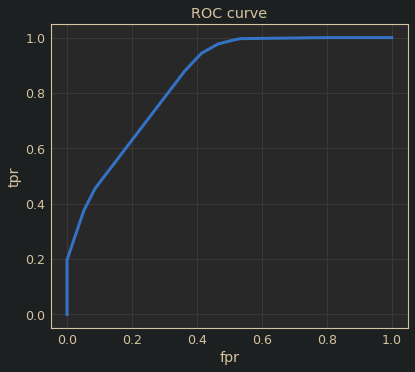

In [6]:
getAuc(X,y,minsplit=2,max_depth=None,n_estimators=1000,USE_ONLY=[1,2])

In [7]:
data=df.copy()
COLS=data.columns
COLS=['i_'+str(x-1) for x in COLS]
COLS[0]='Dx'
data.columns=COLS
data.head()

,Dx,i_1,i_2,i_3,i_4,i_5,i_6,i_7,i_8,i_9,...,i_64,i_65,i_66,i_67,i_68,i_69,i_70,i_71,i_72,i_73
0,,,,,,,,,,,,,,,,,,,,,
1,1,2,2,1,5,1,1,1,1,3,...,1,3,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,3,3,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,0


In [11]:
OUTPUTDIR='./results/'
REGEN=True

In [14]:
# get qnet formatted data
COLS=COLS[1:]
X = data.drop('Dx',axis=1).values.astype(str)
X

array([['2', '2', '1', ..., '1', '1', '1'],
       ['1', '1', '1', ..., '1', '1', '1'],
       ['1', '1', '1', ..., '1', '1', '1'],
       ...,
       ['2', '2', '1', ..., '3', '1', '1'],
       ['2', '2', '2', ..., '4', '5', '1'],
       ['2', '2', '1', ..., '4', '1', '1']], dtype='<U21')

In [15]:
if REGEN:
    qnet = Qnet(n_jobs=12,feature_names=COLS,alpha=.2).fit(X)
    save_qnet(qnet,OUTPUTDIR+'qnet_psychosis.joblib')
else:
    qnet=load_qnet(OUTPUTDIR+'qnet_psychosis.joblib')

In [16]:
Nsteps=1000
index1=len(X)
X_=X

In [17]:
# generate distanec matrix
if REGEN:
    H=qdistance_matrix(X_,X_, qnet, qnet)
    pd.DataFrame(H).to_csv(OUTPUTDIR+'HMAT.csv',index=None,header=None,sep=' ')
    H.shape

In [18]:
# calculate sippl embedding
PREF=OUTPUTDIR
FILE='HMAT.csv'
DATAFILE=PREF+FILE#'data_'
EFILE=PREF+'_Eb1_'
DFILE=PREF+'_Db1_'
PCAEFILE=PREF+'_PEb1_'

In [19]:
if REGEN:
    STR=EMBED+' -f '+DATAFILE+' -E '+EFILE+' -D '+DFILE
    subprocess.call(STR,shell=True);

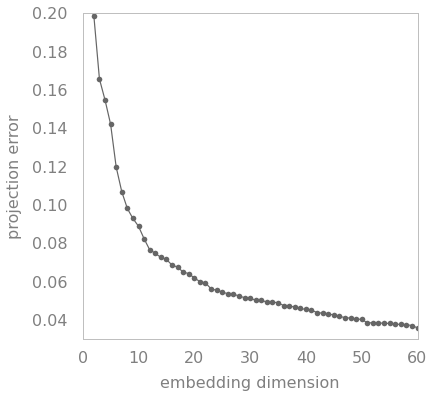

In [20]:
# plot dimensional error
fig=plt.figure(figsize=[6,6])
ax=plt.gca()
ax=pd.read_csv(DFILE,sep=' ',header=None).transpose().plot(ax=ax,style='-ko',c='.4')

ax.set_ylim(3e-2,2e-1)
ax.set_xlim(0,60)

plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
ax.set_ylabel('projection error',fontsize=16,color='.5',labelpad=10)
ax.set_xlabel('embedding dimension',fontsize=16,color='.5',labelpad=10)

l=ax.legend(['dimensional error'],fontsize=16)
l.remove()
    
plt.savefig(OUTPUTDIR+'emderror'+'.png',dpi=600,bbox_inches='tight',transparent=True)    

In [21]:
# get embedding matrix
E=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
E.columns=['x'+str(i) for i in E.columns]
E.to_csv(PREF+'Eb1.csv')

In [22]:
Ef=pd.read_csv(EFILE,sep=' ',header=None).dropna(axis=1).transpose()
Ef.columns=['x'+str(i) for i in Ef.columns]
xf=Ef#.assign(IF=dx.ido)

pca = PCA(n_components=2).fit(xf)
ef=pca.fit_transform(xf)

pd.DataFrame(ef).to_csv(PCAEFILE,header=None,index=None)

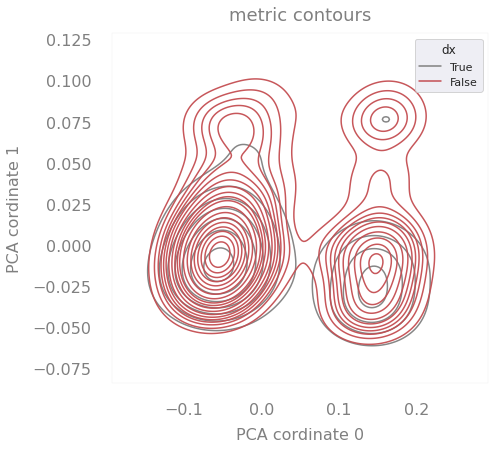

In [24]:
def varname(x):
    if x:
        return 'False'
    return 'True'
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=[6,6])
sns.set()

ax=plt.gca()

pf=pd.DataFrame(ef,columns=['X','Y']).assign(ido=data.Dx)
pf['dx']=(pf.ido==1)
pf['dx']=[varname(x) for x in pf.dx]
ax=sns.kdeplot(x='X',y='Y',fill=False,data=pf,alpha=.95,lw=2,levels=20,thresh=.05,hue='dx',palette=['.5','r'],fontsize=16)

ax.set_title('metric contours',fontsize=18,y=1.02,color='.5')
plt.setp(ax.get_xticklabels(), fontsize=16,y=-.02)
plt.setp(ax.get_yticklabels(), fontsize=16)
#plt.setp(ax2.get_yticklabels(), fontsize=16)
#plt.gca().set_xlabel('% reduction in error', fontsize=16,color='.5')
ax.set_facecolor((1.0, 0.47, 0.42,0))
fig.set_facecolor((1,0,1,0))
ax.spines['bottom'].set_color('.75')
ax.spines['top'].set_color('.75') 
ax.spines['right'].set_color('.75')
ax.spines['left'].set_color('.75')
##ax.set_xlim(-100,100);
ax.grid(color='#dddddd', linestyle='--', linewidth=2)
plt.setp(ax.spines.values(), linewidth=.1)
ax.tick_params(axis='x', colors='.5')    #setting up X-axis tick color to red
ax.tick_params(axis='y', colors='.5',pad=15)  #setting up Y-axis tick color to black
#ax.set_ylabel('density',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)
ax.set_ylabel('PCA cordinate 1',fontsize=16,color='.5',labelpad=10)
ax.set_xlabel('PCA cordinate 0',fontsize=16,color='.5',labelpad=10)
#ax.legend(fontsize=16)


plt.savefig(OUTPUTDIR+'dxcontour'+'.png',dpi=600,bbox_inches='tight',transparent=True)

In [25]:
def getDissonance(sample_index,index=None,MISSING_VAL=np.nan):                                  
    '''                                                                                               
    Dissonnace vector                                                                                                   
    '''  
    if isinstance(sample_index, int):
        s=samples[sample_index]                                                                           
    else:
        s=sample_index
    if index is None:                                                                                 
        index=range(len(s))                                                                           
                                                                                                      
    Ds=qnet.predict_distributions(s)                                                                  
                                                                                                      
    diss=np.ones(len(Ds))*MISSING_VAL                                                                 
    for i in index:                                                                                   
        if s[i] != '':                                                                                
            if s[i] in Ds[i].keys():                                                                  
                diss[i]=1-Ds[i][s[i]]/np.max(                                                         
                    list(Ds[i].values()))                                                             
            else:                                                                                     
                diss[i]=1.0                                                                           
                                                                                                      
    return diss                                                                        

In [26]:
samples=X
from pqdm.processes import pqdm                                                                     
Diss=pqdm(range(len(X)), getDissonance, n_jobs=12)                                                              
Diss=pd.DataFrame(Diss)

SUBMITTING | :   0%|          | 0/644 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/644 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/644 [00:00<?, ?it/s]

In [27]:
Diss.columns=COLS

In [29]:
# we need to generate random responses using base frequency
s_null=['']*len(X[0])
D_null=qnet.predict_distributions(s_null)
D_rnd=[]
nullbp=[]
for i in range(len(X[0])):
    u,c=np.unique(X[:][i], return_counts=True)
    c=c/c.sum()
    D_rnd=np.append(D_rnd,dict(zip(u,c)))
    nullbp=np.append(nullbp,entropy(c,base=len(c)))

nullbp=nullbp/np.sum(nullbp)
def generateNullSample(D):
    choice_=[]
    for i in range(len(D)):
        keys=list(D[i].keys())
        last_=0
        rkey=np.random.random()
        for k in keys:
            last_=D[i][k]+last_
            if rkey <= last_:
                break
        choice_=np.append(choice_,k)
    return choice_
            

len(generateNullSample(D_rnd))

73

In [201]:
Nsteps=5
dissbp=Diss.mean().values
dissbp=dissbp/dissbp.sum()
Xc=[]
for s in X:
    Xc=np.append(Xc,qsample(s,qnet,Nsteps,dissbp))
Xc=Xc.reshape(len(Xc)//73,73)

In [202]:
# compute dissonance for random responses
samples=Xc
from pqdm.processes import pqdm                                                                     
DissC=pqdm(range(len(Xc)), getDissonance, n_jobs=12)                                                              
DissC=pd.DataFrame(DissC)

SUBMITTING | :   0%|          | 0/644 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/644 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/644 [00:00<?, ?it/s]

In [203]:
DissC.columns=COLS

In [204]:
Xci=Xc.astype(int)
X0=X.astype(int)

In [205]:
np.corrcoef(Diss.mean(axis=1).values,y)

array([[1.        , 0.10317188],
       [0.10317188, 1.        ]])

In [206]:
Xplus=np.c_[X0,Diss.mean(axis=1).values]

Xci (0.845905172413793, [RandomForestClassifier(n_estimators=1000), ExtraTreesClassifier(class_weight='balanced', n_estimators=1000)])
X (0.8694581280788177, [RandomForestClassifier(n_estimators=1000), ExtraTreesClassifier(class_weight='balanced', n_estimators=1000)])
Xplus (0.866533251231527, [RandomForestClassifier(n_estimators=1000), ExtraTreesClassifier(class_weight='balanced', n_estimators=1000)])


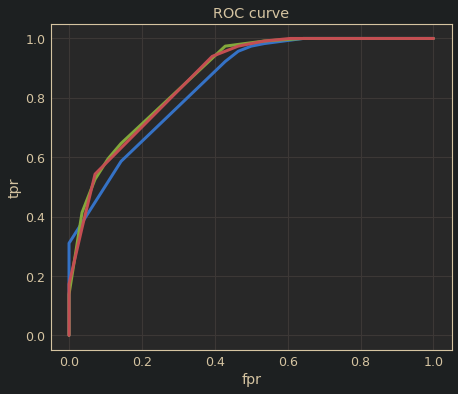

In [210]:
IND=np.random.permutation(len(X))
a1=getAuc(Xci,np.array(y),SPLIT_INDEX=IND[:500],minsplit=2,max_depth=None,n_estimators=1000,USE_ONLY=[1,2])
a2=getAuc(X,np.array(y),SPLIT_INDEX=IND[:500],minsplit=2,max_depth=None,n_estimators=1000,USE_ONLY=[1,2])
a3=getAuc(Xplus,np.array(y),SPLIT_INDEX=IND[:500],minsplit=2,max_depth=None,n_estimators=1000,USE_ONLY=[1,2])
print ('Xci',a1)
print('X',a2)
print('Xplus',a3)

